In [0]:


## A function which takes the img_size, prob_vector and the number of desired samples and pytorch tensor and labels
import numpy as np
import cv2


def generate_img_data(prob_vector, num_samples, img_size = (50, 50)):

  """
    Generate images with circles inside as data
    prob_vector: The probability for the different classes
                  (note that this is hard-coded to three classes: big circle, medium circle and small circle)
    num_samples: Number of desired samples
    img_size: Size of img
  """

  #num_samples_1_train = 5000 
  store_dataset_x = np.zeros((num_samples, img_size[0], img_size[1]))
  store_dataset_y = np.zeros(num_samples)

  num_classes = len(prob_vector)
  #circle_prob_train = np.array([0.2, 0.4, 0.4])
  ind_vec_train = [np.random.choice([kkk for kkk in range(num_classes)], p = prob_vector) for iii in range(num_samples)]

  for kkk in range(num_samples):

    ## Generate random center position of the circle
    centre_row = np.random.randint(15,35)
    centre_col = np.random.randint(15,35)

    ## Generate circle with big, medium or small radius
    if ind_vec_train[kkk] == 0:
      img_rad = np.random.randint(2,4)
    if ind_vec_train[kkk] == 1:
      img_rad = np.random.randint(8,12)
    if ind_vec_train[kkk] == 2:
      img_rad = np.random.randint(14,18)
    
    img = np.zeros(img_size)
    img = cv2.circle(img, (centre_row, centre_col), img_rad, 1, 2)
    store_dataset_x[kkk,:,:] = img
    store_dataset_y[kkk] = ind_vec_train[kkk]

  return store_dataset_x, store_dataset_y



In [0]:
## Just a function to plot some samples to see what it looks like
import matplotlib.pyplot as plt
def plot_img(img_array, num_plots = 4):
    fig, ax = plt.subplots(1, num_plots, figsize=(16,8))
    plot_ind = np.random.randint(0, img_array.shape[0], 4)
    for jjj in range(num_plots):
      ax[jjj].imshow(img_array[plot_ind[jjj],:,:])

    fig.show()

In [0]:

import torch

def create_data_loader(img_array, img_labels, batch_size = 64):
  x_torch = torch.from_numpy(img_array).float()
  x_torch = torch.unsqueeze(x_torch, 1)
  y_torch = torch.from_numpy(img_labels).long()
  data_list = [(x_torch[kkk,:,:,:], y_torch[kkk]) for kkk in range(x_torch.shape[0])]
  data_loader = torch.utils.data.DataLoader(data_list, batch_size = batch_size, shuffle = True)
  return data_loader


In [0]:
import torch.nn as nn
import torch.nn.functional as F


class Network(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 100, 5)
    self.conv2 = nn.Conv2d(100, 60, 5)
    self.conv3 = nn.Conv2d(60, 20, 5)
    self.fc1 = nn.Linear(500, 100)
    self.fc2 = nn.Linear(100, 3)
    self.T = nn.Parameter(torch.tensor(1.))
    self.bias_t = nn.Parameter(torch.zeros(3))

  def train_net(self):
    for param in self.named_parameters():
      
      if param[0] in ['T', 'bias_t']:
        param[1].requires_grad = False
  
  def calibrate(self):
    
    for param in self.named_parameters():
      if param[0] in ['T', 'bias_t']:
        param[1].requires_grad = True
      else:
        param[1].requires_grad = False

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, (2, 2))
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, (2, 2))
    x = F.relu(self.conv3(x))
    x = x.view(x.shape[0],-1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)/self.T + self.bias_t ## For calibration later
    x = F.log_softmax(x, dim = 1)
    return x



In [0]:
def train_network(my_net, train_loader, val_loader, max_epoch = 2, calibrate = False):

  if not calibrate:
    my_net.train_net()
    opt = torch.optim.SGD(my_net.parameters(), lr = 1e-2, momentum = 0.9)
    loss_fn = nn.NLLLoss()


    for epoch in range(max_epoch):

      for data, anno in train_loader:
        
        my_net.zero_grad()
        out = my_net(data)
        loss = loss_fn(out, anno)
        loss.backward()
        opt.step()

      with torch.no_grad():
        acc_v = 0
        for data, anno_v in val_loader:
          my_net.zero_grad()
          out_v = my_net(data)
          loss_v = loss_fn(out_v, anno_v)
          values, indices = torch.max(out_v, 1)
          acc_v = acc_v + torch.sum(indices == anno_v)
        acc_v = acc_v.float() / len(val_loader.dataset)


      print('Epoch {} Train Loss {} Val Loss {} Val Acc {}'.format(epoch, loss.item(), loss_v.item(), acc_v))

  if calibrate: 

    my_net.calibrate()

    opt = torch.optim.SGD(my_net.parameters(), lr = 1e-5, momentum = 0.9)
    loss_fn = nn.NLLLoss()

    for epoch in range(10):
      acc_v = 0
      for data, anno_v in val_loader:
        my_net.zero_grad()
        out_v = my_net(data)
        loss_v = loss_fn(out_v, anno_v)
        loss_v.backward()
        opt.step()
        values, indices = torch.max(out_v, 1)
        acc_v = acc_v + torch.sum(indices == anno_v)
      acc_v = acc_v.float() / len(val_loader.dataset)
      print('Val loss {} Val Acc {}'.format(loss_v, acc_v))

In [0]:
def estimate_class_probabilities(my_net, test_loader, simulated_prob):

  store_probs = []
  for idx, (data, anno_s) in enumerate(test_loader):

    prob = my_net(data)
    if idx == 0:
      store_prob = torch.exp(prob)
    else:
      store_prob = torch.cat((store_prob, torch.exp(prob)))
  ## To get all the probabilities as a numpy array
  prob_source_target = store_prob.detach().numpy()

  ## The algorithm is performed below:
  target_prob = simulated_prob ## Init

  num_iters = 50
  eps = 1e-8

  for kkk in range(num_iters):

    store_target_prob = []

    for aaa in range(prob_source_target.shape[0]):

      p1 = np.log(target_prob) + np.log(prob_source_target[aaa,:] + eps)  - np.log(simulated_prob)
      p2 = np.sum(np.exp(np.log(target_prob) + np.log(prob_source_target[aaa,:] + eps)  - np.log(simulated_prob)))
      prob_targ_cond = np.exp(p1 - np.log(p2))
      store_target_prob.append(prob_targ_cond)
      
    all_probs = np.array(store_target_prob)
    target_prob = np.mean(all_probs, 0)

  return target_prob

The setup is as follows: 
* We have a simulated dataset $(\tilde{x}_i,a_i)$ with consisting of images and their corresponding annotations. These samples are assumed to follow a joint distribution $p(\tilde{x},a)$ which induces a marginal distribution over the annotations $p(a)$
* We have an observed dataset with images $(x_i)$ with unobserved annotations sampled from a joint distribution $Q(x,a)$ which induces a marginal distribution $q(a)$.
* The goal is to determine the difference between $p(a)$ and $q(a)$.

We can do this with an assumption of label shift. The main assumption here is that $p(x|a) = q(x|a)$ (with QD and SD thise assumption would be that given an annotation the distribution for the images would be the same which to me does not hold since the images look different, but we might be able to argue instead that $p(f(x)|a) = q(f(x)|a)$ where $f$ is the neural network mapping into a latent space. So given an annotation, the distribution in the latent space should be the same for the two datasets which might be sort of true if we can assume that the network extracts some underlying characteristics of our data) and that the difference in the joint distribution arises from the fact that $p(a) \neq q(a)$.

Lets try a simple example and see how it works. 
* We create an image dataset where we have circles with three possible classes: Big circle, medium circle and small circle.
* We create a set to act as SD where we have the probabilities [0.2, 0.4,0.4] for the three classes and a set to act as QD (note that $G=G^*$ here) with probabilities [0.2,0.7,0.1].
* Goal is to obtain an estimate of the distribution [0.2,0.7,0.1] over the QD set.



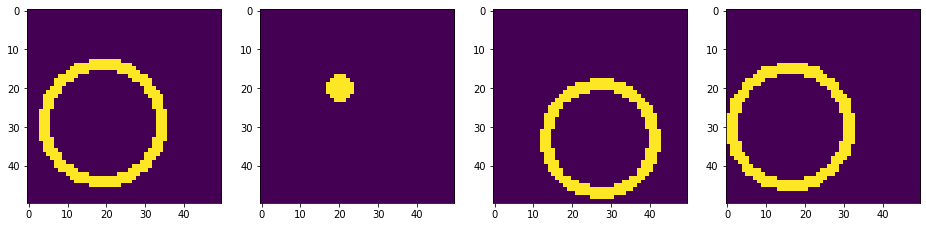

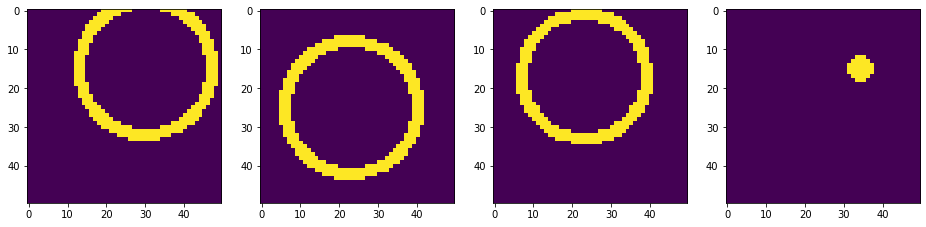

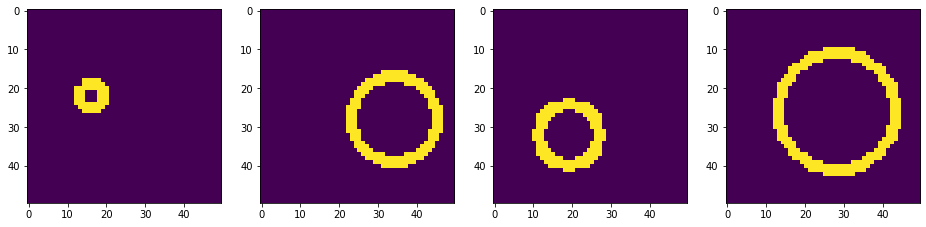

In [27]:
## This is the main file then

## The probabilities for the three classes
##    Small circle, medium circle, big circle
simulate_prob_vec = [0.2,0.4,0.4] ## This is the probabilities for the simulated data
observed_prob_vec = [0.2,0.7,0.1] ## These are the probabilities we want to infer


num_train_samples = 5000
num_val_samples = 1000
num_test_samples = 15000

x_train, y_train = generate_img_data(simulate_prob_vec, num_train_samples)
x_val, y_val = generate_img_data(simulate_prob_vec, num_val_samples)
x_test, y_test = generate_img_data(observed_prob_vec, num_val_samples)

## Just to see the dataset
## There is no difference between G and G* now.
plot_img(x_train) 
plot_img(x_val)
plot_img(x_test)


In [28]:
## Train the network and calibrate it
train_loader = create_data_loader(x_train, y_train)
val_loader = create_data_loader(x_val, y_val)
test_loader = create_data_loader(x_test, y_test)

my_net = Network()
train_network(my_net, train_loader, val_loader, calibrate = False)
print('Calibrating the network')
train_network(my_net, train_loader, val_loader, calibrate = True)

Epoch 0 Train Loss 0.11778327077627182 Val Loss 0.04885342717170715 Val Acc 0.9860000014305115
Epoch 1 Train Loss 0.00048001279355958104 Val Loss 0.0022883680649101734 Val Acc 1.0
Calibrating the network
Val loss 0.00040808686753734946 Val Acc 1.0
Val loss 0.00028041511541232467 Val Acc 1.0
Val loss 0.0005068840691819787 Val Acc 1.0
Val loss 0.0010371885728091002 Val Acc 1.0
Val loss 0.0006770615582354367 Val Acc 1.0
Val loss 0.0013925096718594432 Val Acc 1.0
Val loss 0.0005729129770770669 Val Acc 1.0
Val loss 0.0005144446040503681 Val Acc 1.0
Val loss 0.0014219331787899137 Val Acc 1.0
Val loss 0.008515631780028343 Val Acc 1.0


In [29]:
## Estimate the annotation probabilties
estimated_prob = estimate_class_probabilities(my_net, test_loader, simulate_prob_vec)
print('The true probabilities are {}'.format(observed_prob_vec))
print('The estimated probabilities are {}'.format(estimated_prob))

The true probabilities are [0.2, 0.7, 0.1]
The estimated probabilities are [0.21178482 0.6925973  0.09561789]


In [32]:
## We can now gauge the differences in the annotation distribution between the two sets
prob_diff = np.abs(estimated_prob - simulate_prob_vec)
print(prob_diff) ## Values close to 0 indicate our expectations coincide with the reality for that annotation.

[0.01178482 0.2925973  0.30438211]


So in this simple example we could see that the method gives quite good results. Some issues and questions:
* Now I only worked with three annotations, big, medium, small. For this setting it is easy to construct a network that predicts these three annotations well from the images. But if we have many annotations, like brightness can range from 0-255, bounding box corner can range from 0-20 etc. This creates a huge classification problem for the network. And I think we somehow need it to be a classification problem because the method relies on $p(a|x)$ being probabilities. So if one wants to train a network to predict bounding box coordinates with mean squared loss then one has to find a way to convert the corresponding values to probabilities before applying the algorithm.
* A possible solution to the above problem would be to work with annotations on different levels. So create "large" annotation classes and see if the expectations on the simulated dataset match those on the observed dataset first. And then find the areas where the expectations are mismatched and explore those further. For example, in the example above we could see that our expectation for the small circle class have been met and thus we can maybe just continue with investigating the large and medium class and create/modify a network to predict these better. This could be done by creating new classes such as "medium circles in top right corner, medium circle in bottom left, etc" and then apply the same method and see where the expectations differ now.
* Now there is no difference in $G$ and $G^*$ for the train and test set but this might affect the end results as well.
* I also mentioned in the beginning that we might be able to assume $p(f(x)|a) = q(f(x)|a)$ but maybe one needs to think more about this.
* Also the dataset here might be a bit too easy and that is why the results are so good here.
